<a href="https://colab.research.google.com/github/sandhya212/AM_HS/blob/main/Attention_model_Lung1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [31]:
def get_mean_std_many(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [38]:
def get_mean_std(images):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0

    batch_size=1
    num_channels = 3
    height = 1008
    width = 1344

    num_pixels += batch_size * height * width
    mean += images.mean(axis=(0, 2, 3)).sum()
    std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [3]:
## torch hub

In [2]:
patch_size = 8
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 90.8MB/s]


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [5]:
for p in model.parameters():
        p.requires_grad = False
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [8]:
## read in the file

In [94]:
import os
os.getcwd()

'/content'

In [211]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
#img_npy = Image.open(BytesIO(response.content))

#img_npy = Image.open('../content/Beg_7Color_47_Screnning_9_18_2018_2ndScan_[43997,15863]_composite_image.tif')

#set 1
'''
img_comp = Image.open('../content/Beg_7Color_47_Screnning_9_18_2018_2ndScan_[39636,15839]_composite_image.tif')
img_npy = Image.open('../content/Beg_7Color_47_Screnning_9_18_2018_2ndScan_[39636,15839]_component_data.tif')
img_npy = img_comp.convert('RGB')
'''

#set 2

img_comp = Image.open('../content/Beg_7Color_47_Screnning_9_18_2018_2ndScan_[40503,15806]_composite_image.tif')
img_npy = Image.open('../content/Beg_7Color_47_Screnning_9_18_2018_2ndScan_[40503,15806]_component_data.tif')
img_npy = img_npy.convert('RGB')

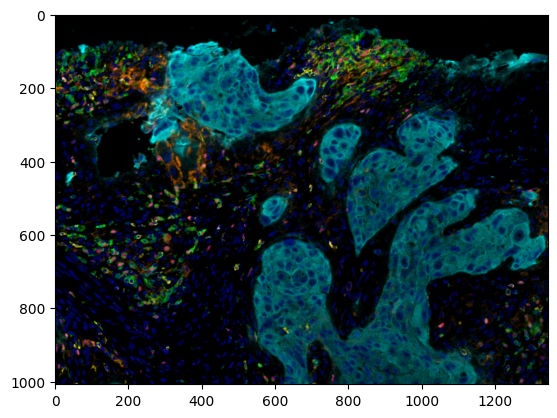

In [212]:
plt.imshow(img_comp)

In [213]:
#batch_size = 32
#loader = torch.utils.data.DataLoader(img_npy, batch_size=batch_size, shuffle=True)


#####mean, std = get_mean_std(img_npy)

In [214]:
### code the attention map

In [215]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #pth_transforms.Normalize((0.825, 0.828, 0.828), (0.029, 0.024, 0.025)),
])
img = transform(img_npy)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

#attentions = model.forward_selfattention(img.cuda())
attentions = model.get_last_selfattention(img)#.cuda())

In [216]:
print(type(img))
print(img.shape)

<class 'torch.Tensor'>
torch.Size([1, 3, 1008, 1344])


In [217]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

In [218]:
nh

6

In [219]:
attentions.shape

torch.Size([6, 5292])

In [220]:
threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()
# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

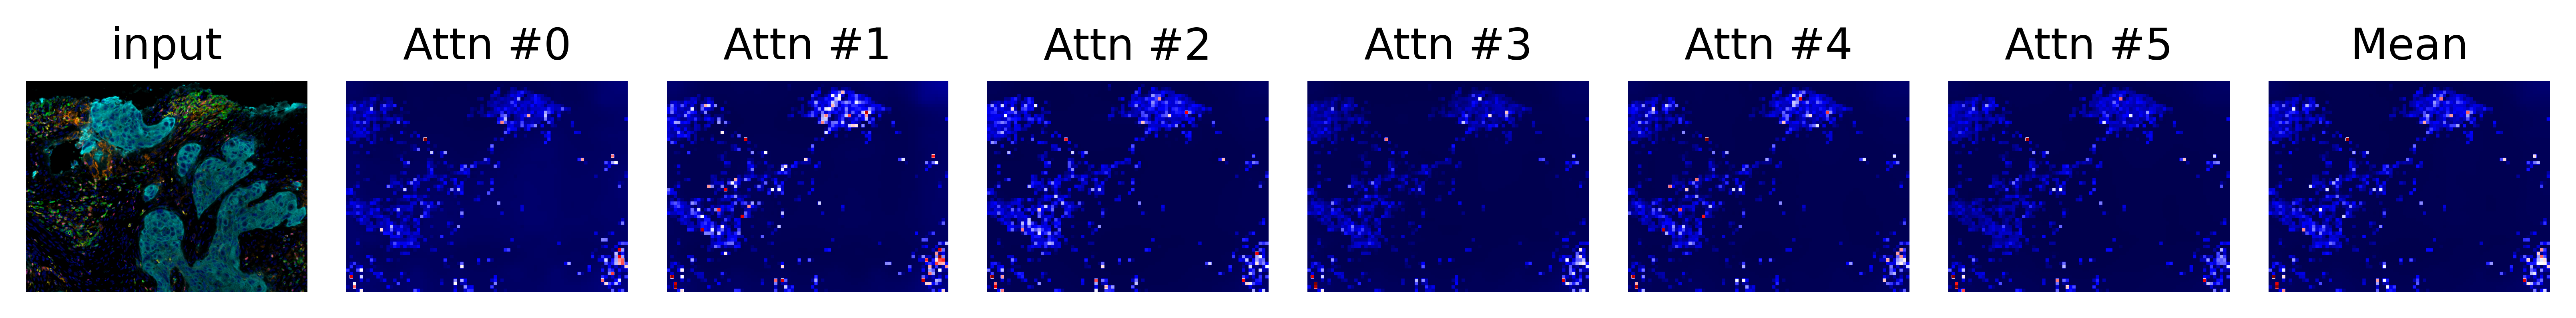

In [221]:
plt.figure(figsize=(10, 3), dpi=650)
plt.subplot(1, nh+2, 1)
plt.title("input")
plt.imshow(img_comp,cmap='seismic')
plt.axis("off")
# visualize self-attention of each head

for i in range(nh):
  plt.subplot(1, nh+2, i+2)
  plt.title("Attn #"+str(i))
  plt.imshow(attentions[i],cmap='seismic')
  plt.axis("off")

plt.subplot(1, nh+2, nh+2)
plt.title("Mean")
plt.imshow(attentions_mean,cmap='seismic')
plt.axis("off")
plt.tight_layout()

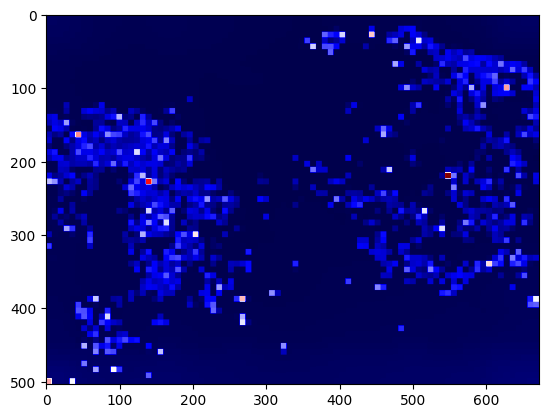

In [186]:
plt.imshow(attentions[i],cmap='seismic')